# Custom training

Sometimes, I don't know when or even why, but sometimes, you would want to write the training loop on your own, and when that happens you may find this helpful (and while you are at it, tell me why you are doing this).

So far, we talked about customizing multiple parts of the process, like the loss function, building your own custom layers, and callbacks, now we will implement the training loop that tensorflow works with using `GradientTape` and see how metrics are calculated within it.

For the purposes of this notebook, we will be using the Fashion MNIST dataset, with a model built with the squential API (we are customizing the training not the model).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the data
import tensorflow_datasets as tfds

train_data = tfds.load('fashion_mnist', split="train")
test_data = tfds.load('fashion_mnist', split="test")

def format_image(data):
  image = data["image"]
  image = tf.reshape(image, [-1])
  image = tf.cast(image, 'float32')
  image = image / 255.0
  return image, data["label"]

train_data = train_data.map(format_image)
test_data = test_data.map(format_image)

batch_size = 64

train_data = train_data.shuffle(1024).batch(batch_size) # Shuffle the data with a buffer size of 1024 (this helps with small memory size)
test_data = test_data.batch(batch_size)

In [3]:
# Define the model
model = tf.keras.models.Sequential([
  tf.keras.Input(shape=(784,)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

From this cell forward, we will be implementing everything our selves, albeit with a bit of help from the `GradientTape` API, and other tensorflow functions, we are just connecting them together.

In [4]:
# Define the loss function
# We will use sparse_categorical_crossentropy
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

# Define the optimizer
# We will use Adam
optimizer = tf.keras.optimizers.Adam()

# Define the metrics
# We will use accuracy
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
validation_metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

# train step

We will make a function that does the training for 1 batch of data, and update the model. it should return the predictions (which is needed for the metrics) and the losses (for plotting).

In [5]:
def train_step(train_data, train_labels, model, optimizer, loss_fn):
  with tf.GradientTape() as tape:
    predictions = model(train_data)
    loss = loss_fn(train_labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return predictions, loss

# Epoch

We will create a function that handles training for one epoch. all it does is calling `train_step` for all batches in the training set provided, then update the metrics.

In [6]:
def train_for_epoch(train_data, model, optimizer, loss_fn, metrics):
  losses = []
  for (batch, (train_x, train_y)) in enumerate(train_data):
    predictions, loss = train_step(train_x, train_y, model, optimizer, loss_fn)
    losses.append(loss.numpy())
  
    for metric in metrics:
      metric.update_state(train_y, predictions)

  return losses


In [7]:
def apply_validation(test_data, model, loss_fn, metrics):
  losses = []
  for (batch, (test_x, test_y)) in enumerate(test_data):
    predictions = model(test_x)
    loss = loss_fn(test_y, predictions)
    losses.append(loss.numpy())

    for metric in metrics:
      metric.update_state(test_y, predictions)
  return losses

In [8]:
def train(data, model, optimizer, loss_fn, metrics, epochs):
  train_metrics, validation_metrics = metrics
  train, test = data

  history = {
    'train_loss': [],
    'validation_loss': [],
  }
  for epoch in range(epochs):
    # train for one epoch
    losses = train_for_epoch(train, model, optimizer, loss_fn, train_metrics)

    # compute training metrics
    metrics_values = {m.name: m.result() for m in train_metrics}
    for metric in train_metrics:
      metric.reset_states()
    
    # compute validation losses
    val_losses = apply_validation(test, model, loss_fn, validation_metrics)
    
    # compute validation metrics
    val_metrics_values = {m.name: m.result() for m in validation_metrics}
    for metric in validation_metrics:
      metric.reset_states()

    # compute training and validation loss
    mean_loss = np.mean(losses)
    mean_val_loss = np.mean(val_losses)
    history['train_loss'].append(mean_loss)
    history['validation_loss'].append(mean_val_loss)

    # print metrics
    print("Epoch: {}, Loss: {}, Validation Loss: {}".format(epoch, mean_loss, mean_val_loss))
    print(', '.join(["train_{}: {}".format(k, v) for k, v in metrics_values.items()]))
    print(', '.join(["val_{}: {}".format(k, v) for k, v in val_metrics_values.items()]))
    print()
  
  return history

In [9]:
history = train(
  data=(train_data, test_data), 
  model=model, 
  optimizer=optimizer, 
  loss_fn=loss_fn, 
  metrics=(metrics, validation_metrics), 
  epochs=10
)

Epoch: 0, Loss: 0.5363800525665283, Validation Loss: 0.4358713924884796
train_sparse_categorical_accuracy: 0.8123000264167786
val_sparse_categorical_accuracy: 0.8457000255584717

Epoch: 1, Loss: 0.3871501684188843, Validation Loss: 0.4001929759979248
train_sparse_categorical_accuracy: 0.8608499765396118
val_sparse_categorical_accuracy: 0.8568000197410583

Epoch: 2, Loss: 0.35358989238739014, Validation Loss: 0.37780216336250305
train_sparse_categorical_accuracy: 0.8716999888420105
val_sparse_categorical_accuracy: 0.8675000071525574

Epoch: 3, Loss: 0.3306913375854492, Validation Loss: 0.3715239465236664
train_sparse_categorical_accuracy: 0.879016637802124
val_sparse_categorical_accuracy: 0.8702999949455261

Epoch: 4, Loss: 0.3126378059387207, Validation Loss: 0.3604251742362976
train_sparse_categorical_accuracy: 0.8846166729927063
val_sparse_categorical_accuracy: 0.8748999834060669

Epoch: 5, Loss: 0.29853934049606323, Validation Loss: 0.3783731460571289
train_sparse_categorical_accura

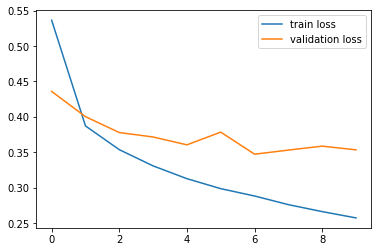

In [11]:
# plot the training and validation loss
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['validation_loss'], label='validation loss')
plt.legend()